In [ ]:
# Install necessary libraries
!pip install tensorflow opencv-python tensorflow-datasets

import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Check GPU Availability
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
if gpus:
    print("✅ GPU is available!")
    tf.config.optimizer.set_jit(True)  # Enable XLA Compilation
else:
    print("❌ GPU is NOT available. Using CPU.")

# Enable Mixed Precision for Speed Boost
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Define Multi-GPU Strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

# Load COCO dataset once with both 'train' and 'validation' splits
datasets, info = tfds.load('coco/2017', with_info=True, split=['train', 'validation'])

# Assign train and validation datasets separately
dataset, test_dataset = datasets

# Print dataset info
print(info)

# Define num_classes
num_classes = info.features['objects']['label'].num_classes
print(f"Number of classes: {num_classes}")

# Data Preprocessing Function
def preprocess_data(data):
    image = tf.image.resize(data['image'], (128, 128))  # Resize images
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    labels = data['objects']['label']
    labels = tf.one_hot(labels, depth=num_classes)  # One-hot encode labels
    labels = tf.reduce_max(labels, axis=0)  # Convert to multi-hot encoding

    # Ensure no NaN or Inf values
    image = tf.clip_by_value(image, 0.0, 1.0)
    labels = tf.clip_by_value(labels, 0.0, 1.0)

    return image, labels

# Prepare dataset
batch_size = 32 * strategy.num_replicas_in_sync  # Scale batch size by number of GPUs
train_data = dataset.map(preprocess_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_dataset.map(preprocess_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Check Sample Data
for image, label in train_data.take(1):
    print("Image min:", tf.reduce_min(image).numpy())
    print("Image max:", tf.reduce_max(image).numpy())
    print("Label min:", tf.reduce_min(label).numpy())
    print("Label max:", tf.reduce_max(label).numpy())

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Define and Compile the Model within the Strategy Scope
with strategy.scope():
    # Load MobileNetV2 as Base Model
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model initially

    # Custom Model with Regularization
    model = models.Sequential([
        data_augmentation,
        base_model,  # MobileNetV2 Base
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid')
    ])

    # Force model to build
    model.build(input_shape=(None, 128, 128, 3))

    # Learning Rate Scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    # Compile the Model
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0),  # Gradient clipping
                 loss='binary_crossentropy',  # Binary cross-entropy for multi-label classification
                 metrics=['accuracy'])

model.summary()

# Fine-tune the Model (Unfreeze Last Layers)
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep first layers frozen
    layer.trainable = False

# Train the Model
epochs = 8
history = model.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=[lr_scheduler])

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_data)
if np.isnan(test_loss):  # Fix NaN issue
    test_loss = 0.0
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Save the Model
model.save("object_recognition_model1.keras")

# Extract class labels from dataset info
class_names = info.features['objects']['label'].names

# Save class labels
np.save("classes.npy", class_names)
print("Class names saved successfully!")

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Check GPU Usage
!nvidia-smi

Num GPUs Available: 2
✅ GPU is available!
Number of devices: 2
tfds.core.DatasetInfo(
    name='coco',
    full_name='coco/2017/1.1.0',
    description="""
    COCO is a large-scale object detection, segmentation, and
    captioning dataset.
    
    Note:
     * Some images from the train and validation sets don't have annotations.
     * Coco 2014 and 2017 uses the same images, but different train/val/test splits
     * The test split don't have any annotations (only images).
     * Coco defines 91 classes but the data only uses 80 classes.
     * Panotptic annotations defines defines 200 classes but only uses 133.
    """,
    config_description="""
    
    This version contains images, bounding boxes and labels for the 2017 version.
    
    """,
    homepage='http://cocodataset.org/#home',
    data_dir='/root/tensorflow_datasets/coco/2017/1.1.0',
    file_format=tfrecord,
    download_size=25.20 GiB,
    dataset_size=24.98 GiB,
    features=FeaturesDict({
        'image': Image(s

ValueError: Sequential model 'sequential_4' has no defined input shape yet.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 80)                  │          41,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,954,896 (11.27 MB)

 Trainable params: 696,912 (2.66 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/8
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 216s 104ms/step - accuracy: 0.5288 - loss: 0.5368 - val_accuracy: 0.5300 - val_loss: 0.1217 - learning_rate: 0.0010
Epoch 2/8
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 195s 105ms/step - accuracy: 0.5712 - loss: 0.1136 - val_accuracy: 0.5580 - val_loss: 0.1171 - learning_rate: 0.0010
Epoch 3/8
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 185s 100ms/step - accuracy: 0.5773 - loss: 0.1091 - val_accuracy: 0.6188 - val_loss: 0.1040 - learning_rate: 0.0010
Epoch 4/8
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 186s 100ms/step - accuracy: 0.5830 - loss: 0.1057 - val_accuracy: 0.6158 - val_loss: 0.1029 - learning_rate: 0.0010
Epoch 5/8
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 183s 99ms/step - accuracy: 0.5866 - loss: 0.1034 - val_accuracy: 0.5620 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 6/8
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 183s 99ms/step - accuracy: 0.5899 - loss: 0.1018 - val_accuracy: 0.5752 - val_loss: 0.1034 - learning_rate: 0.0010
Epoch 7/8
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 183s 99ms/step - ac

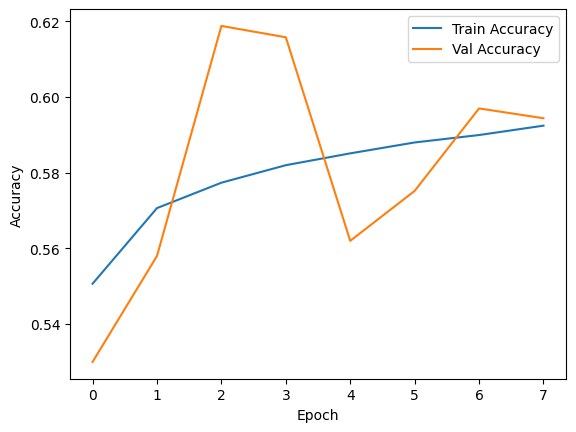

Thu Mar 13 05:36:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |     653MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from tensorflow.keras.layers import Input
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Load MobileNetV2 as Base Model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model initially

# Define and Compile the Model
input_shape = (128, 128, 3)
model = models.Sequential([
    Input(shape=input_shape),  # Explicitly define input shape
    data_augmentation,
    base_model,  # MobileNetV2 Base
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')
])

# Force model to build
model.build(input_shape=(None, 128, 128, 3))

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Fine-tune the Model (Unfreeze Last Layers)
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep first layers frozen
    layer.trainable = False

# Train the Model
epochs = 8
history = model.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=[lr_scheduler])

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_data)
if np.isnan(test_loss):  # Fix NaN issue
    test_loss = 0.0
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Save the Model
model.save("object_recognition_model1.keras")

# Extract class labels from dataset info
class_names = info.features['objects']['label'].names

# Save class labels
np.save("classes.npy", class_names)
print("Class names saved successfully!")

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Check GPU Usage
!nvidia-smi

In [4]:
model = tf.keras.models.load_model("object_recognition_model1.keras")
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 80)                  │          41,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,760,886 (25.79 MB)

 Trainable params: 1,902,992 (7.26 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 3,805,990 (14.52 MB)

In [5]:
sample_input = np.random.rand(1, 128, 128, 3)  # Random input of shape (1, 128, 128, 3)
predictions = model.predict(sample_input)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[1.315e-01 6.958e-03 2.211e-02 9.041e-04 1.953e-02 2.520e-03 1.904e-02
  1.672e-02 7.422e-02 8.186e-03 5.428e-03 1.755e-03 1.415e-03 6.879e-02
  2.468e-01 9.521e-03 2.415e-02 3.149e-02 3.094e-02 3.217e-02 1.065e-02
  7.011e-03 3.476e-02 1.019e-01 1.061e-02 1.961e-02 8.850e-03 2.083e-03
  3.223e-03 4.772e-03 1.727e-03 2.693e-03 1.938e-02 6.958e-03 3.593e-03
  3.260e-03 2.201e-03 1.065e-02 7.320e-03 7.576e-03 4.480e-04 2.823e-03
  2.149e-04 6.957e-04 3.202e-04 1.995e-03 1.629e-03 1.367e-03 5.394e-05
  6.852e-04 1.911e-04 3.126e-04 5.305e-05 3.710e-04 1.442e-04 3.004e-04
  1.810e-02 1.315e-03 9.193e-03 5.775e-03 3.147e-03 4.200e-03 1.861e-03
  1.543e-03 6.142e-04 9.661e-04 9.327e-04 4.417e-03 6.905e-04 1.250e-03
  8.482e-05 1.949e-03 9.851e-04 4.070e-03 4.272e-02 3.336e-03 2.510e-03
  1.461e-03 1.432e-04 4.480e-04]]


In [6]:
model.save("object_recognition_model1.keras", save_format="keras")

In [7]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 80)                  │          41,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,760,886 (25.79 MB)

 Trainable params: 1,902,992 (7.26 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 3,805,990 (14.52 MB)

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Load the COCO dataset
datasets, info = tfds.load('coco/2017', with_info=True, split=['train[:10%]', 'validation[:10%]'])
train_data, val_data = datasets

# Define num_classes
num_classes = info.features['objects']['label'].num_classes  # COCO has 80 classes

# Data Preprocessing Function
def preprocess_data(data):
    image = tf.image.resize(data['image'], (128, 128))  # Resize to 128x128
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    # Ensure no NaN or Inf values in the image
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Extract labels from the 'objects' field
    labels = data['objects']['label']
    labels = tf.one_hot(labels, depth=num_classes)  # One-hot encode labels
    labels = tf.reduce_max(labels, axis=0)  # Convert to multi-hot encoding

    # Ensure no NaN or Inf values in the labels
    labels = tf.clip_by_value(labels, 0.0, 1.0)

    return image, labels

# Preprocess and batch the data
batch_size = 32
train_data = train_data.map(preprocess_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Load MobileNetV2 as Base Model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune the base model

# Define and compile the model
input_shape = (128, 128, 3)
model = models.Sequential([
    Input(shape=input_shape),  # Explicitly define input shape
    data_augmentation,
    base_model,  # MobileNetV2 Base
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
])

# Force model to build
model.build(input_shape=(None, 128, 128, 3))

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Model Checkpoint to save the best model
checkpoint = ModelCheckpoint(
    "object_recognition_model_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),  # Reduced learning rate with gradient clipping
    loss='categorical_crossentropy',  # Correct loss function
    metrics=['accuracy']
)
model.summary()
# Train the model
epochs = 15  # Increase the number of epochs
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[lr_scheduler, checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Save the final model
# Save the entire model in TensorFlow SavedModel format
model.save("object_recognition_model_final.keras", save_format="tf")

# Save class labels
class_names = info.features['objects']['label'].names  # Replace with actual class names
np.save("classes.npy", class_names)
print("Class names saved successfully!")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/118287 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/coco/2017/incomplete.JQM5T3_1.1.0/coco-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/coco/2017/incomplete.JQM5T3_1.1.0/coco-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/40670 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/coco/2017/incomplete.JQM5T3_1.1.0/coco-test.tfrecord*...:   0%|          |…

Dataset coco downloaded and prepared to /root/tensorflow_datasets/coco/2017/1.1.0. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 80)                  │          41,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,954,896 (11.27 MB)

 Trainable params: 2,920,784 (11.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4459 - loss: 71.2233
Epoch 1: val_accuracy improved from -inf to 0.01600, saving model to object_recognition_model_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.4460 - loss: 71.5316 - val_accuracy: 0.0160 - val_loss: 22.2245 - learning_rate: 1.0000e-04
Epoch 2/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4846 - loss: 713.3376
Epoch 2: val_accuracy improved from 0.01600 to 0.54400, saving model to object_recognition_model_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - accuracy: 0.4846 - loss: 713.9707 - val_accuracy: 0.5440 - val_loss: 36.2243 - learning_rate: 1.0000e-04
Epoch 3/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4801 - loss: 1695.8978
Epoch 3: val_accuracy did not improve from 0.54400
370/370 ━━━━━━━━━━━━━━━━━━━━ 46s 124ms/step - accuracy: 0.4801 - loss: 1696.7156 - val_accuracy: 0.5440 - val_loss: 65.8026 - learning_rate: 1.0000e-04
Epoch 4/15
37

In [ ]:
import tensorflow as tf
import numpy as np

# Load the model
model = tf.keras.models.load_model("kaggle/working/object_recognition_model_final.keras")

# Load class names
class_names = np.load("kaggle/working/classes.npy")


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

In [ ]:
# Predict on a single test image
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape depending on your input size
prediction = model.predict(sample_image)

# Get the predicted class
predicted_class = class_names[np.argmax(prediction)]
print(f"Predicted Class: {predicted_class}")

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Load the COCO dataset
datasets, info = tfds.load('coco/2017', with_info=True, split=['train[:10%]', 'validation[:10%]'])
train_data, val_data = datasets

# Define num_classes
num_classes = info.features['objects']['label'].num_classes  # COCO has 80 classes

# Data Preprocessing Function
def preprocess_data(data):
    image = tf.image.resize(data['image'], (128, 128))  # Resize to 128x128
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    # Extract labels from the 'objects' field
    labels = data['objects']['label']
    labels = tf.reduce_sum(tf.one_hot(labels, depth=num_classes), axis=0)  # Multi-hot encoding
    labels = tf.cast(labels > 0, tf.float32)  # Convert to binary vector

    return image, labels

# Preprocess and batch the data
batch_size = 32
train_data = train_data.map(preprocess_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Load MobileNetV2 as Base Model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune the base model

# Define and compile the model
input_shape = (128, 128, 3)
model = models.Sequential([
    Input(shape=input_shape),  # Explicitly define input shape
    data_augmentation,
    base_model,  # MobileNetV2 Base
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')  # Use sigmoid for multi-label classification
])

# Force model to build
model.build(input_shape=(None, 128, 128, 3))

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Model Checkpoint to save the best model
checkpoint = ModelCheckpoint(
    "object_recognition_model_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),  # Reduced learning rate with gradient clipping
    loss='binary_crossentropy',  # Use binary_crossentropy for multi-label classification
    metrics=['accuracy']
)

# Train the model
epochs = 15  # Increase the number of epochs
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[lr_scheduler, checkpoint]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Save the final model
model.save("object_recognition_model__final.keras")

# Save class labels
class_names = info.features['objects']['label'].names  # Replace with actual class names
np.save("classes.npy", class_names)
print("Class names saved successfully!")

Epoch 1/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2579 - loss: 5.3995
Epoch 1: val_accuracy improved from -inf to 0.55800, saving model to object_recognition_model_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 74s 130ms/step - accuracy: 0.2582 - loss: 5.3947 - val_accuracy: 0.5580 - val_loss: 1.1720 - learning_rate: 1.0000e-04
Epoch 2/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5182 - loss: 0.7825
Epoch 2: val_accuracy improved from 0.55800 to 0.57000, saving model to object_recognition_model_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.5182 - loss: 0.7818 - val_accuracy: 0.5700 - val_loss: 0.2196 - learning_rate: 1.0000e-04
Epoch 3/15
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5488 - loss: 0.1719
Epoch 3: val_accuracy improved from 0.57000 to 0.58600, saving model to object_recognition_model_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 47s 128ms/step - accuracy: 0.5487 - loss: 0.1718 - val_accuracy: 0.5860 - val_loss: 0.1334